In [10]:
import pandas as pd 
import pydot
import numpy as np 
import tensorflow as tf
import os
from glob import glob
from PIL import Image
import shutil
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import warnings

from IPython.display import clear_output

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from mlxtend.plotting import plot_confusion_matrix

seed = (4,2)

In [11]:
os.listdir('D:\HAM')

['HAM10000_images_part_1',
 'HAM10000_images_part_2',
 'HAM10000_metadata.csv',
 'hmnist_28_28_L.csv',
 'hmnist_28_28_RGB.csv',
 'hmnist_8_8_L.csv',
 'hmnist_8_8_RGB.csv']

In [12]:
warnings.filterwarnings('ignore')

In [13]:
df = pd.read_csv('D:\HAM\HAM10000_metadata.csv')

size = (64, 64)

In [14]:
base_dir = 'D:\HAM'
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_dir, '*', '*.jpg'))}

In [15]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize(size))/ 255)

In [16]:
df = df[['dx', 'image']]

In [17]:
df.head()

,dx,image
0,bkl,"[[[0.7490196078431373, 0.596078431372549, 0.76..."
1,bkl,"[[[0.09019607843137255, 0.050980392156862744, ..."
2,bkl,"[[[0.7294117647058823, 0.5058823529411764, 0.5..."
3,bkl,"[[[0.09411764705882353, 0.043137254901960784, ..."
4,bkl,"[[[0.5450980392156862, 0.37254901960784315, 0...."


In [18]:
df['dx'].value_counts()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

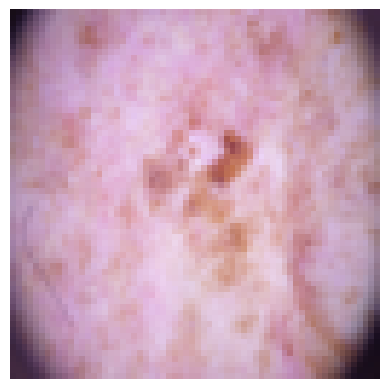

In [19]:
arr = df.iloc[1]['image']
#Image.fromarray(arr)
plt.imshow(arr)
plt.axis('off') 
plt.show()

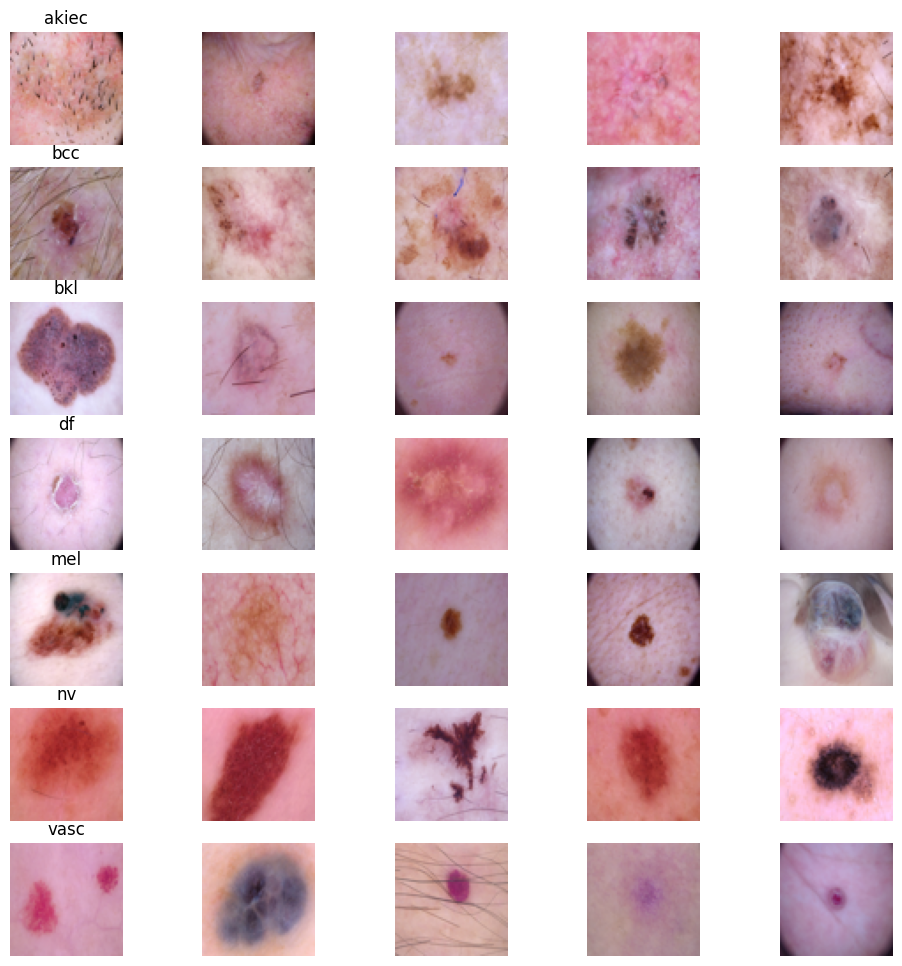

In [20]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (12,12))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=42).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
# fig.savefig('category_samples.png', dpi=300)

In [21]:
counts = pd.DataFrame(df['dx'].value_counts()).reset_index()
counts

,dx,count
0,nv,6705
1,mel,1113
2,bkl,1099
3,bcc,514
4,akiec,327
5,vasc,142
6,df,115


In [22]:
df_df = df[df['dx'] == 'df']
vasc_df = df[df['dx'] == 'vasc']
akiec_df = df[df['dx'] == 'akiec']
bcc_df = df[df['dx'] == 'bcc']
bkl_df = df[df['dx'] == 'bkl']
mel_df = df[df['dx'] == 'mel']

In [14]:
#Аугментация данных

In [23]:
def aug_brightness(img_arr):    
    aug_arr = tf.image.stateless_random_brightness(img_arr, 0.7, seed)
    aur_arr = np.array(aug_arr)
    
    return aug_arr

def aug_contrast(img_arr):    
    aug_arr = tf.image.stateless_random_contrast(img_arr, 0.2, 0.8, seed)
    aur_arr = np.array(aug_arr)
    
    return aug_arr

def aug_flip_left_right(img_arr):    
    aug_arr = tf.image.stateless_random_flip_left_right(img_arr, seed).numpy().tolist()
    aur_arr = np.array(aug_arr)
    
    return aug_arr

def aug_flip_up_down(img_arr):    
    aug_arr = tf.image.stateless_random_flip_up_down(img_arr, seed).numpy().tolist()
    aur_arr = np.array(aug_arr)
    
    return aug_arr

def aug_hue(img_arr):    
    aug_arr = tf.image.stateless_random_hue(img_arr, 0.5, seed)
    aur_arr = np.array(aug_arr)
    
    return aug_arr

def aug_saturation(img_arr):    
    aug_arr = tf.image.stateless_random_saturation(img_arr, 0.1, 1, seed)
    aur_arr = np.array(aug_arr)
    
    return aug_arr

In [24]:
func_list = [aug_brightness, aug_contrast, aug_flip_left_right, aug_flip_up_down, aug_hue, aug_saturation]

In [25]:
def random_augmentation(images, dx, num_of_samples):
    new_images = []
    all_indices = []
    while (len(new_images) < num_of_samples):
        indices = np.random.randint(images.shape[0], size=6)
        r = list(map(lambda x, y: x(y), func_list, images.iloc[indices]))
        r = [np.array(tensor) for tensor in r]
        new_images.extend(r)
        all_indices.extend(indices)
        clear_output(wait=True)
        print(str(len(new_images)) + '/' + str(num_of_samples))
    
    new_images = pd.DataFrame({'dx': dx, 'image': new_images})
    
    return all_indices, new_images

In [26]:
df_images = df_df['image']
df_indices, df_new_images = random_augmentation(df_images, 'df', 700)

702/700


In [27]:
vasc_images = vasc_df['image']
vasc_indices, vasc_new_images = random_augmentation(vasc_images, 'vasc', 700)

702/700


In [28]:
akiec_images = akiec_df['image']
akiec_indices, akiec_new_images = random_augmentation(akiec_images, 'akiec', 1000)

1002/1000


In [29]:
bcc_images = bcc_df['image']
bcc_indices, bcc_new_images = random_augmentation(bcc_images, 'bcc', 1200)

1200/1200


In [30]:
bkl_images = bkl_df['image']
bkl_indices, bkl_new_images = random_augmentation(bkl_images, 'bkl', 1400)

1404/1400


In [31]:
mel_images = mel_df['image']
mel_indices, mel_new_images = random_augmentation(mel_images, 'mel', 1400)

1404/1400


In [32]:
new_images_df = pd.concat([df_new_images, vasc_new_images, akiec_new_images, bcc_new_images, bkl_new_images, mel_new_images], axis=0).reset_index(drop=True)
aug_df = pd.concat([df, new_images_df], axis=0).reset_index(drop=True)
aug_df = aug_df.sample(frac=1).reset_index(drop=True)

In [33]:
pd.DataFrame(aug_df['dx'].value_counts()).reset_index()

,dx,count
0,nv,6705
1,mel,2517
2,bkl,2503
3,bcc,1714
4,akiec,1329
5,vasc,844
6,df,817


In [34]:
aug_df.shape

(16429, 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


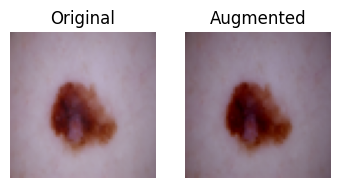

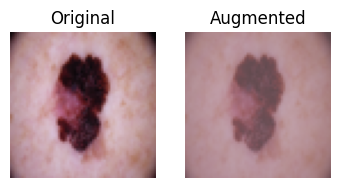

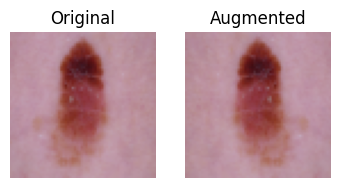

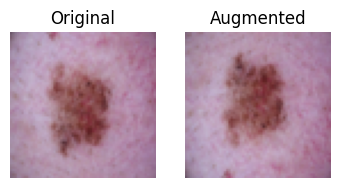

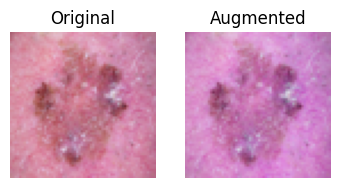

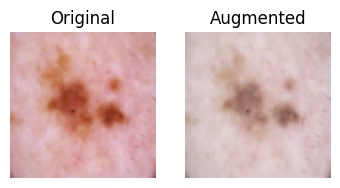

In [35]:
for i in range(12, 18):
    plt.subplot(1, 3, 1) 
    plt.imshow(mel_df['image'].iloc[mel_indices[i]])
    plt.title('Original')
    plt.axis('off')

    plt.subplot(1, 3, 2) 
    plt.imshow(mel_new_images['image'].iloc[i])
    plt.title('Augmented')
    plt.axis('off')
    
    plt.show()

In [36]:
labelEncoder = LabelEncoder()
aug_df['label'] = labelEncoder.fit_transform(aug_df['dx'])

In [37]:
x = np.asarray(aug_df['image'].to_list())
y = to_categorical(aug_df['label'], num_classes=7)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.20, random_state=42, shuffle=True)

In [ ]:
#Создание модели

In [38]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=(64, 64, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization() ,
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu', kernel_initializer='he_normal'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform')
])


model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:

early_stopping = EarlyStopping(monitor='val_loss', patience=7)

history = model.fit(x_train, y_train, epochs=50, batch_size=8, validation_data=(x_test, y_test), callbacks=[early_stopping])

In [40]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)

103/103 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.8204 - loss: 0.6152
Test Accuracy: 0.8234935998916626
Test Loss: 0.5801200866699219


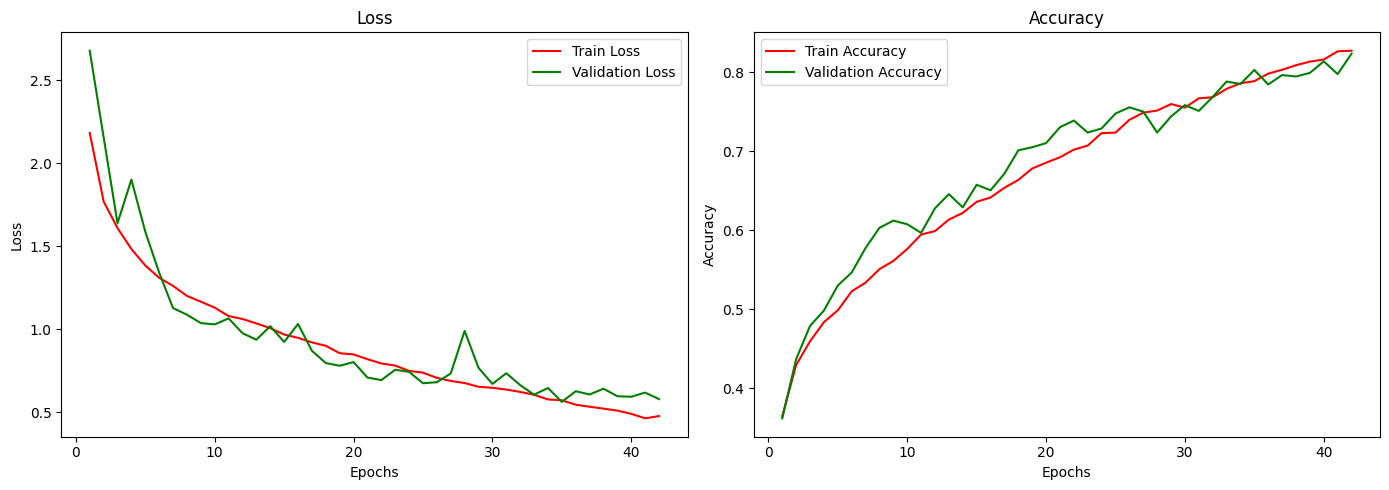

In [41]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

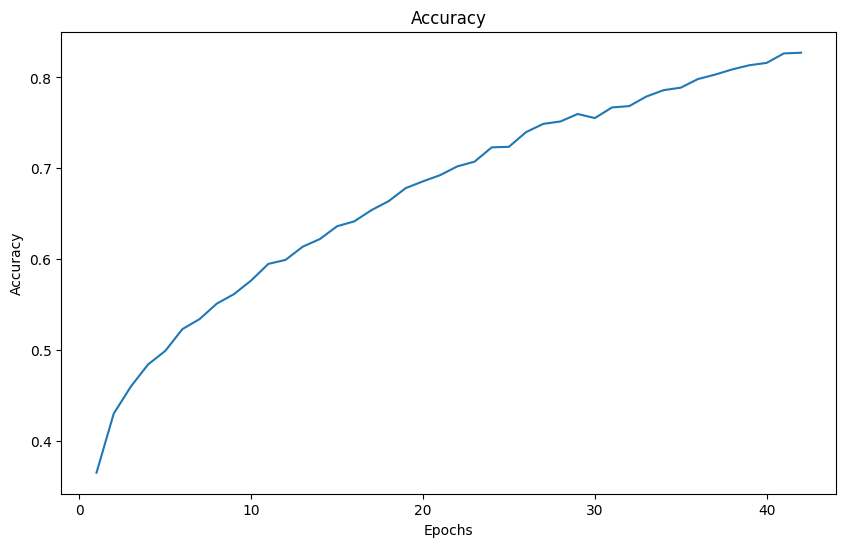

In [42]:
tr_acc = history.history['accuracy']

epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, tr_acc)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

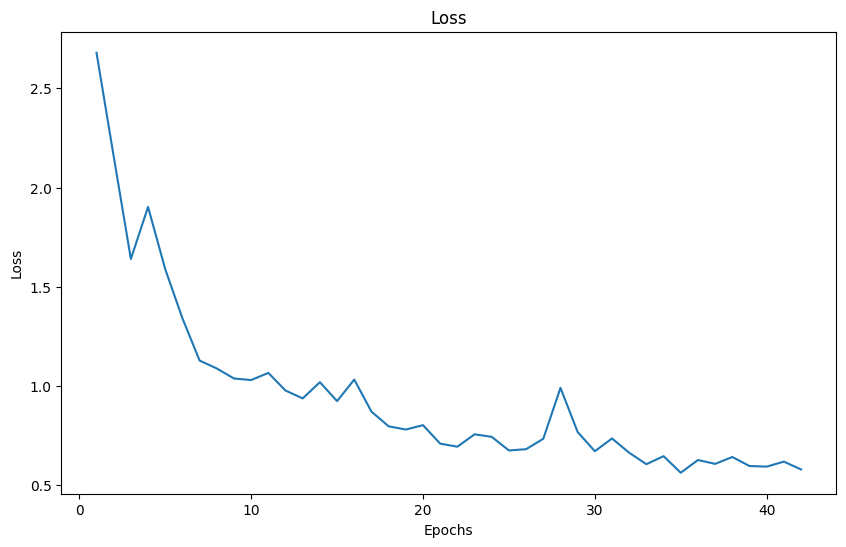

In [43]:
tr_acc = history.history['val_loss']

epochs = range(1, len(tr_acc) + 1)

plt.figure(figsize=(10, 6))

plt.plot(epochs, tr_acc)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=50)

In [45]:
predictions = model.predict(x_test)

103/103 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step


In [46]:
cm = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
cm

array([[ 239,   13,   15,    0,   12,    7,    0],
       [  20,  295,    6,    2,   10,    7,    0],
       [  13,   13,  358,    1,   45,   85,    0],
       [   0,    1,    2,  151,    0,    9,    0],
       [  16,   19,   43,    1,  302,  104,    1],
       [   6,   16,   43,    4,   58, 1207,    0],
       [   0,    2,    0,    0,    1,    5,  154]], dtype=int64)

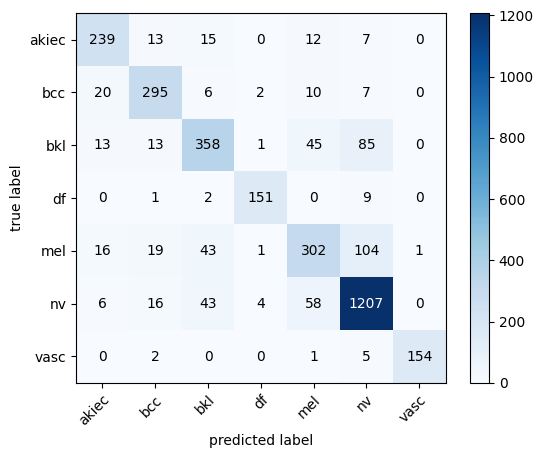

In [47]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

fig, ax = plot_confusion_matrix(conf_mat=cm, class_names=cm_plot_labels, colorbar=True)
plt.show()

In [48]:
report = classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=cm_plot_labels, output_dict=True)

df_classification_report = pd.DataFrame(report).transpose()
df_classification_report.drop(["accuracy", "macro avg", "weighted avg"], inplace=True)
df_classification_report = df_classification_report.sort_values(by=['f1-score'], ascending=False)
df_classification_report["precision"] = df_classification_report["precision"].map(lambda x: round(x, 3))
df_classification_report["recall"] = df_classification_report["recall"].map(lambda x: round(x, 3))
df_classification_report["f1-score"] = df_classification_report["f1-score"].map(lambda x: round(x, 3))
df_classification_report["support"] = df_classification_report["support"].map(int)
df_classification_report

,precision,recall,f1-score,support
vasc,0.994,0.951,0.972,162
df,0.950,0.926,0.938,163
nv,0.848,0.905,0.875,1334
bcc,0.822,0.868,0.844,340
akiec,0.813,0.836,0.824,286
bkl,0.767,0.695,0.729,515
mel,0.706,0.621,0.661,486


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


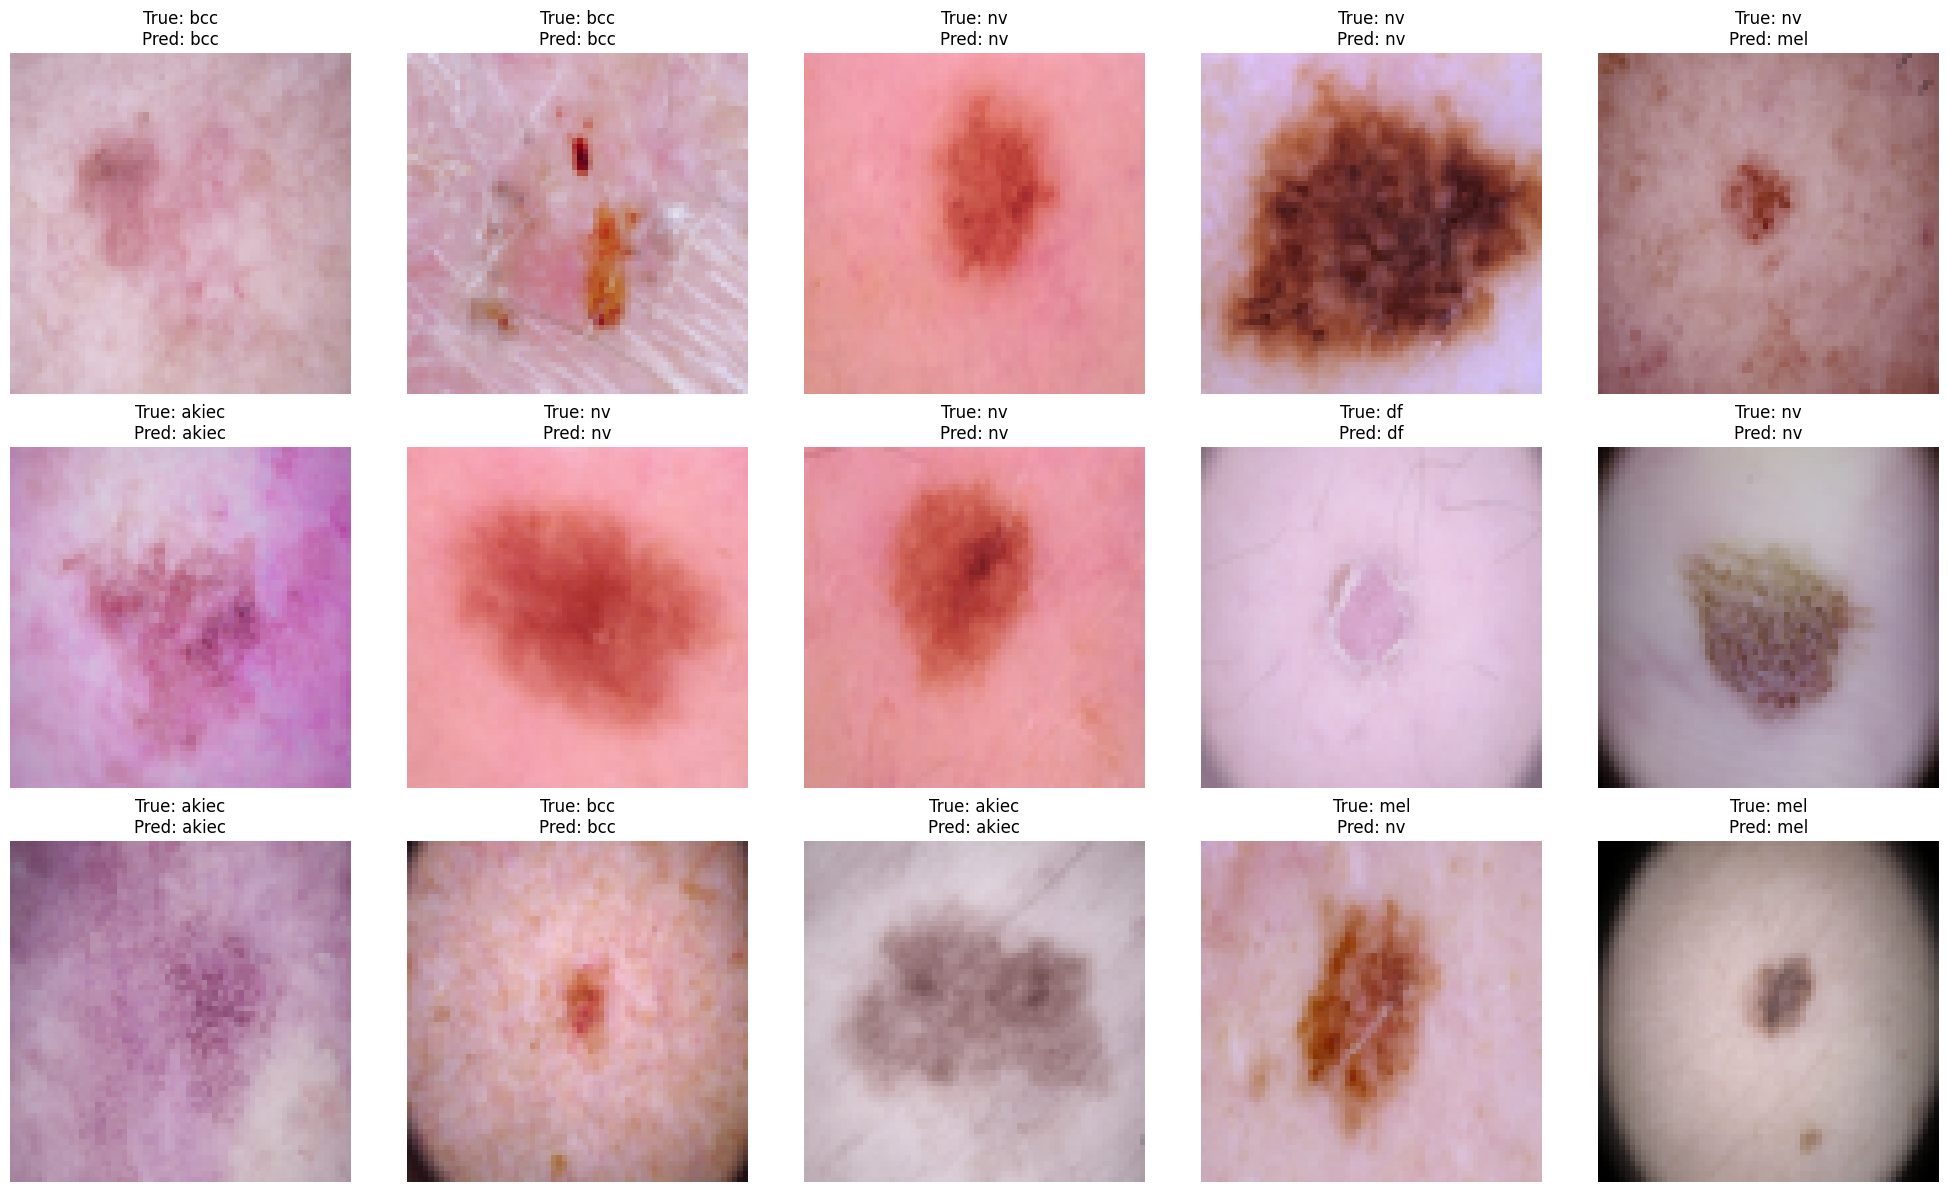

In [79]:
import random


class_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


def display_image_with_labels(ax, image, true_label, predicted_label):
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f"True: {class_labels[true_label]}\nPred: {class_labels[predicted_label]}")
 
    if true_label == predicted_label:
        ax.set_xlabel(f"Match: {class_labels[true_label]}", color='green')
    else:
        ax.set_xlabel(f"Mismatch: True-{class_labels[true_label]}\nPred-{class_labels[predicted_label]}", color='red')


fig, axes = plt.subplots(3, 5, figsize=(20, 12))

for ax in axes.flat:
    
    random_idx = random.randint(0, len(x_test) - 1)

    
    random_image = x_test[random_idx]
    true_label = y_test[random_idx].argmax()

    
    predicted_label = model.predict(np.expand_dims(random_image, axis=0)).argmax()

    
    display_image_with_labels(ax, random_image, true_label, predicted_label)

plt.tight_layout()
plt.show()
